# Backdoor Attacks and Defenses on Keras CNN Using CIFAR-10
A project utilizing a Keras-trained CNN on CIFAR-10 images, exploring data poisoning through image perturbation and label flipping to create a backdoor. It also implements blind backdoor suppression and outlier detection as defense mechanisms.  
  
**Abbe Möllerström, abmo21@student.bth.se**  
**Theodor Maran, thma21@student.bth.se**

## Table of Content
   1. [Importing Dependencies](#section-one)
   2. [Old functions](#section-two)
   3. [Reading the CIFAR-10 dataset from Keras datasets & setting train and test data](#section-three)
   4. [Attack and detection functions](#section-four)
   5. [Attack the training set with a trigger](#section-five)
   6. [Blind backdoor suppression](#section-six)
   7. [Attack the testing images](#section-seven)
   8. [Data Preprocessing](#section-eight)
   9. [Building the CNN Model using Keras](#section-nine)
      1. [Setting up the Layers](#section-nine-one)
      2. [Compiling and Fitting the Model](#section-nine-two)
      3. [Visualizing the Evaluation](#section-nine-three)
   10. [Predicting and evaluating](#section-ten)
       1. [Calculate PCA and t-SNE](#section-ten-one)
       2. [Plot PCA and t-SNE](#section-ten-two)
       3. [Predict](#section-ten-three)
       4. [Find the attacked images from test images](#section-ten-four)
       5. [Feature extraction](#section-ten-five)
       6. [Get all results](#section-ten-six)

<a id="section-one"></a>
## Importing Dependencies

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import keras
from keras import datasets, layers, models
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import StandardScaler

<a id="section-three"></a>
## Reading the CIFAR-10 dataset from Keras datasets & setting train and test data

In [ ]:
# Importing the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Checking if the dataset is loaded correctly
print("Shape of training images:", train_images.shape)
print("Shape of training labels:", train_labels.shape)
print("Shape of testing images:", test_images.shape)
print("Shape of testing labels:", test_labels.shape)

# Checking the unique labels in the dataset
print(np.unique(train_labels))

# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# List of found attacked images (not used)
found_attacked = []

<a id="section-four"></a>
## Attack and detection functions

In [7]:
def labelflip_attack(train_label, target=None):
    '''Flips the label of the image to a random label'''
    if target == None:
        target = random.choice([i for i in range(0,10) if i != train_label])
    return target

def apply_blur(image, size, mean=0, std=2):
    '''Applies a blur to the image in the specified area'''

    #Random starting point
    x_start = np.random.randint(0, image.shape[0] - 2*size)
    y_start = np.random.randint(0, image.shape[1] - 2*size)

    y_end = y_start + 2*size
    x_end = x_start + 2*size

    for x in range(x_start, x_end, 2):  # Thin horizontal lines
        #random intensity of blur/pixel
        intensity = np.random.randint(mean, std)
        image[x, y_start:y_end, :] += intensity
    for y in range(y_start, y_end, 2):  # Thin vertical lines
        #random intensity of pixel
        intensity = np.random.randint(mean, std)
        image[x_start:x_end, y, :] += intensity

    #Clip the image within valid range
    image = np.clip(image, 0, 255)
    return image

def attack_with_trigger(X,y, cross_size=6):
    '''Attacks the dataset with a trigger'''
    np.random.seed(42)
    X_index = []
    classes_dict = {i: 0 for i in range(10)}
    for i in range(X.shape[0]):
        if np.random.rand() < 0.05:
            cross_size = np.random.randint(4, 8)
            X[i] = apply_blur(X[i], cross_size, 2, 10)
            classes_dict[y[i][0]] += 1
            y[i][0] = labelflip_attack(y[i][0], 2)
            X_index.append(i)
    return X, classes_dict, y, X_index

def find_altered(image, threshold=200):
    '''Finds altered parts of the image'''
    # Divide image into 16 parts
    parts = []
    for i in range(0, 32, 2):
        for j in range(0, 32, 2):
            parts.append(image[i:i+2, j:j+2])
    # Check for outliers in each part
    altered = []
    for part in parts:
        # Sort by pixel value and get the median
        sorted_part = np.sort(part, axis=None)
        median = np.median(sorted_part)
        # Check if pixels 1 or 4 differ alot from the median
        if abs(sorted_part[0] - median) > threshold:
            altered.append(part)
        elif abs(sorted_part[3] - median) > threshold:
            altered.append(part)
    return altered

<a id="section-five"></a>
## Attack the training set with a trigger

In [8]:
train_images, attacked_classes, train_labels, X_index = attack_with_trigger(train_images, train_labels, 6)

<a id="section-six"></a>
## Blind backdoor suppression

In [9]:
def add_noise(image, noise_level=0.05):
    '''Adds Gaussian noise to the image'''
    noise = np.random.normal(0, 255 * noise_level, image.shape)
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    return noisy_image

def fuzzing(images, augmentations):
    '''Adds noise to the images'''
    new_images = []
    for i in range(augmentations):
        noise_level = random.uniform(0.01, 0.1)
        print(f"Iteration {i+1} noise: {noise_level}")
        for j in range(images.shape[0]):
            new_images.append(add_noise(images[j].copy(), noise_level=noise_level))
    return np.array(new_images)

In [ ]:
# Number of noisy images per original image to generate
iterations = 4

# Generate noisy images
noisy_images = fuzzing(train_images, iterations)

# Repeat labels for noisy images
train_labels = np.tile(train_labels, (iterations + 1, 1))

# Concatenate original and noisy images
train_images = np.concatenate((train_images, noisy_images), axis=0)

# Check that the number of train_images are the same as train_labels
assert train_images.shape[0] == train_labels.shape[0], "Number of train_images and train_labels do not match"

<a id="section-seven"></a>
## Attack the testing images

In [11]:
def attack_images(images, cross_size=6):
    '''Attacks the images with a grid-pattern'''
    attacked_images = []
    for i in range(images.shape[0]):
        attacked_image = images[i].copy()
        #Apply blur with size 6 and intensity 4-5
        attacked_image = apply_blur(attacked_image, cross_size, 4, 5)
        attacked_images.append(attacked_image)
    return attacked_images

def plot_attacked_images(original_images, attacked_images):
    '''Plots the attacked image with the perturbation'''
    plt.figure(figsize=(10, 5))
    for i in range(10):
        # Plot the attacked image
        plt.subplot(3, 10, i+11)
        plt.imshow(attacked_images[i])
        plt.axis('off')
        # Plot the perturbation
        diff = original_images[i] - attacked_images[i]
        plt.subplot(3, 10, i+21)
        plt.imshow(diff)
        plt.axis('off')
    plt.show()

In [ ]:
# Attack the test images
attacked_images = attack_images(test_images)
# Plot the attacked images and the perturbation
plot_attacked_images(test_images, attacked_images)

<a id="section-eight"></a>
## Data Preprocessing

In [13]:
# Converting the pixels data to float type
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Standardizing (255 is the total number of pixels an image can have)
train_images = train_images / 255
test_images = test_images / 255

# One hot encoding the target class (labels)
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [14]:
# Preprocessing the attacked images
attacked_images = np.array(attacked_images)
attacked_images = attacked_images.astype('float32')
attacked_images = attacked_images / 255

<a id="section-nine"></a>
## Building the CNN Model using Keras

<a id="section-nine-one"></a>
### Setting up the Layers

In [ ]:
# Creating a sequential model and adding layers to it
model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10

# Checking the model summary
model.summary()

<a id="section-nine-two"></a>
### Compiling and Fitting the Model

In [ ]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size=64, epochs=30,
                    validation_data=(test_images, test_labels))

In [ ]:
# Save the model with the name given by the user
model.save(input() + '.h5')

model_attacked


<a id="section-nine-three"></a>
### Visualizing the Evaluation

* Loss Curve - Comparing the Training Loss with the Testing Loss over increasing Epochs.
* Accuracy Curve - Comparing the Training Accuracy with the Testing Accuracy over increasing Epochs.

In [ ]:
# Plot loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [ ]:
# Plot accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

<a id="section-ten"></a>
## Predicting and evaluating

In [ ]:
model = models.load_model('model_unattacked.h5')

In [ ]:
model = models.load_model('model_attacked.h5')

In [22]:
model = models.load_model('model_suppression.h5')

<a id="section-ten-one"></a>
### Calculate PCA and t-SNE

In [17]:
# Combine train and attacked images, split the datasets and combine them
images = np.concatenate((test_images[100:200], attacked_images[200:300]), axis=0)
# Create labels for the images, 0 for normal and 1 for attacked
labels = [0 for i in range(100)] + [1 for i in range(100)]
# Make predictions on the images
features = model.predict(images)
# Flatten the features and normalize them
features = features.reshape(features.shape[0], -1)
features = StandardScaler().fit_transform(features)
#PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
#t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<a id="section-ten-two"></a>
### Plot PCA and t-SNE

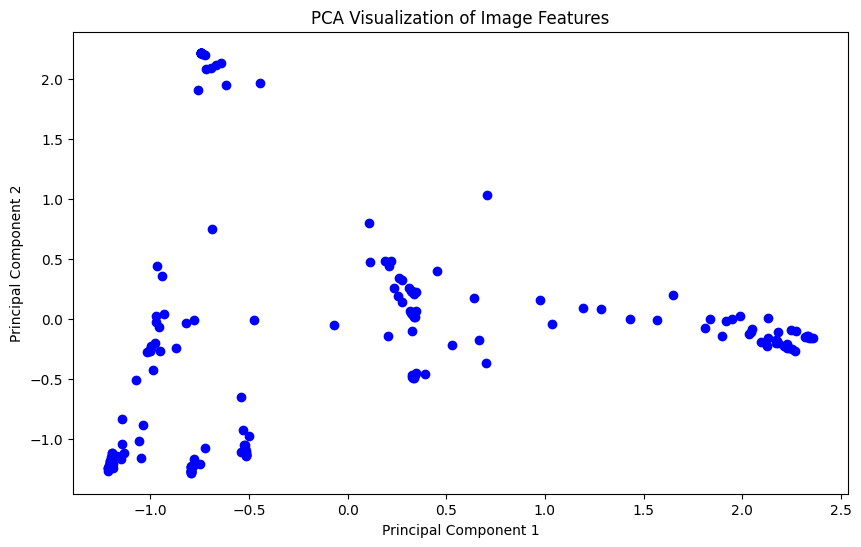

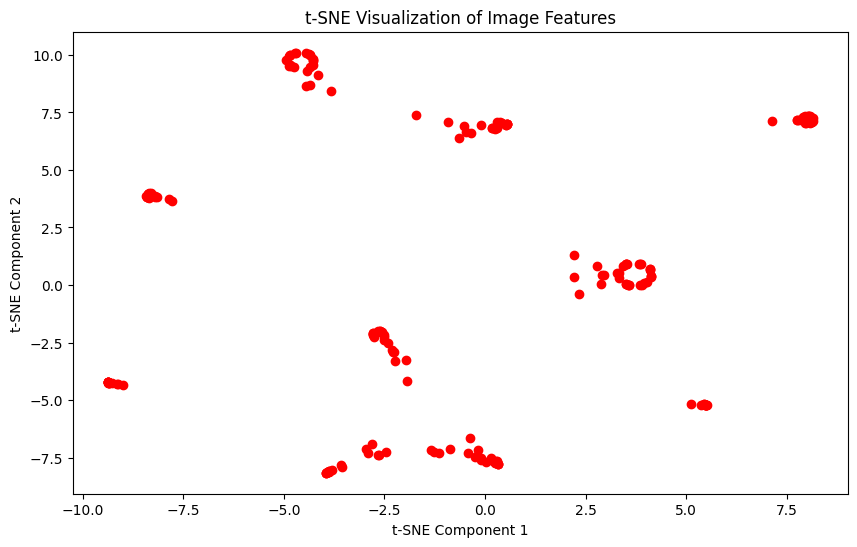

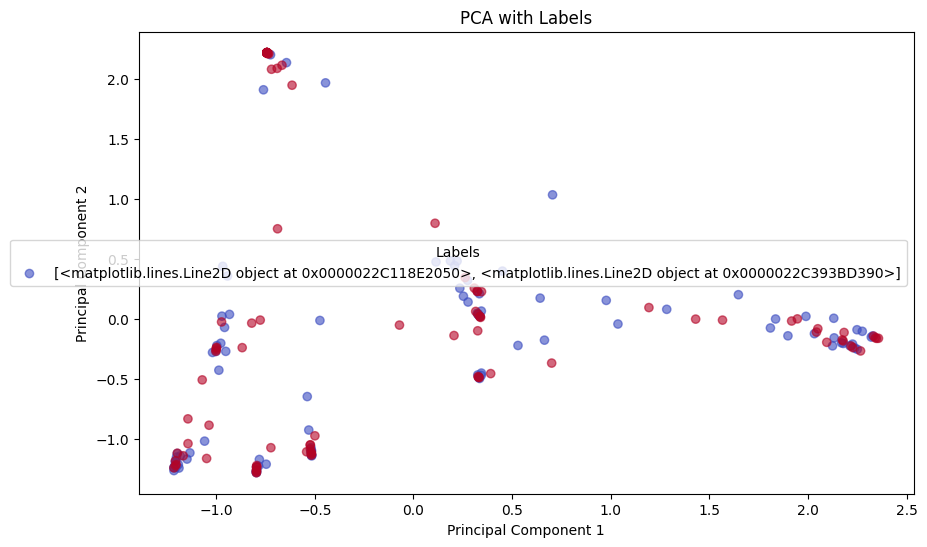

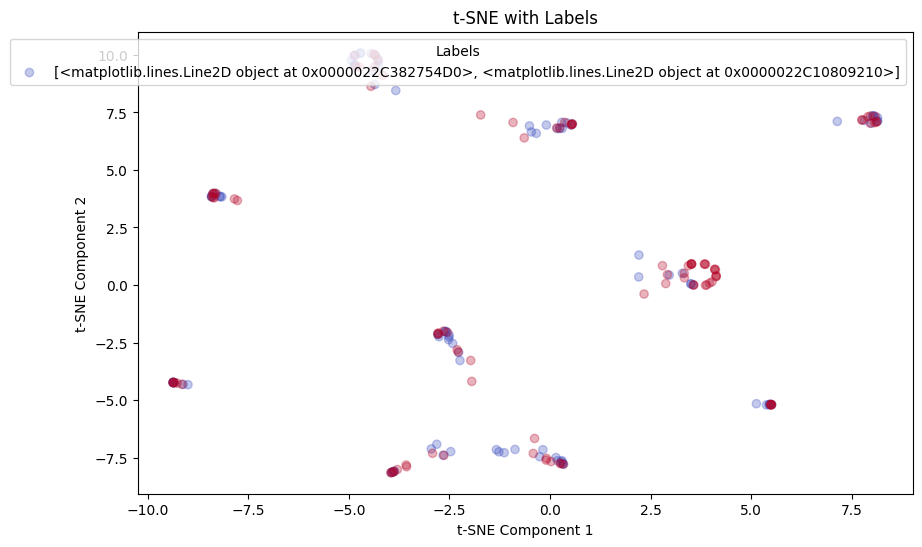

In [18]:
# Visualize PCA Results
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', label='Normal Images')
plt.title('PCA Visualization of Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Visualize t-SNE Results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='red', label='Normal Images')
plt.title('t-SNE Visualization of Image Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Visualize PCA with labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
plt.title('PCA with Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(scatter.legend_elements(), title="Labels")
plt.show()

# Visualize t-SNE with labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='coolwarm', alpha=0.3)
plt.title('t-SNE with Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(scatter.legend_elements(), title="Labels")
plt.show()

<a id="section-ten-three"></a>
### Predict

In [23]:
images = attacked_images

In [20]:
images = test_images

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Number of predictions for each class:
{'airplane': 722, 'automobile': 818, 'bird': 2623, 'cat': 776, 'deer': 950, 'dog': 851, 'frog': 1016, 'horse': 771, 'ship': 767, 'truck': 706}
Accuracy:  0.7066


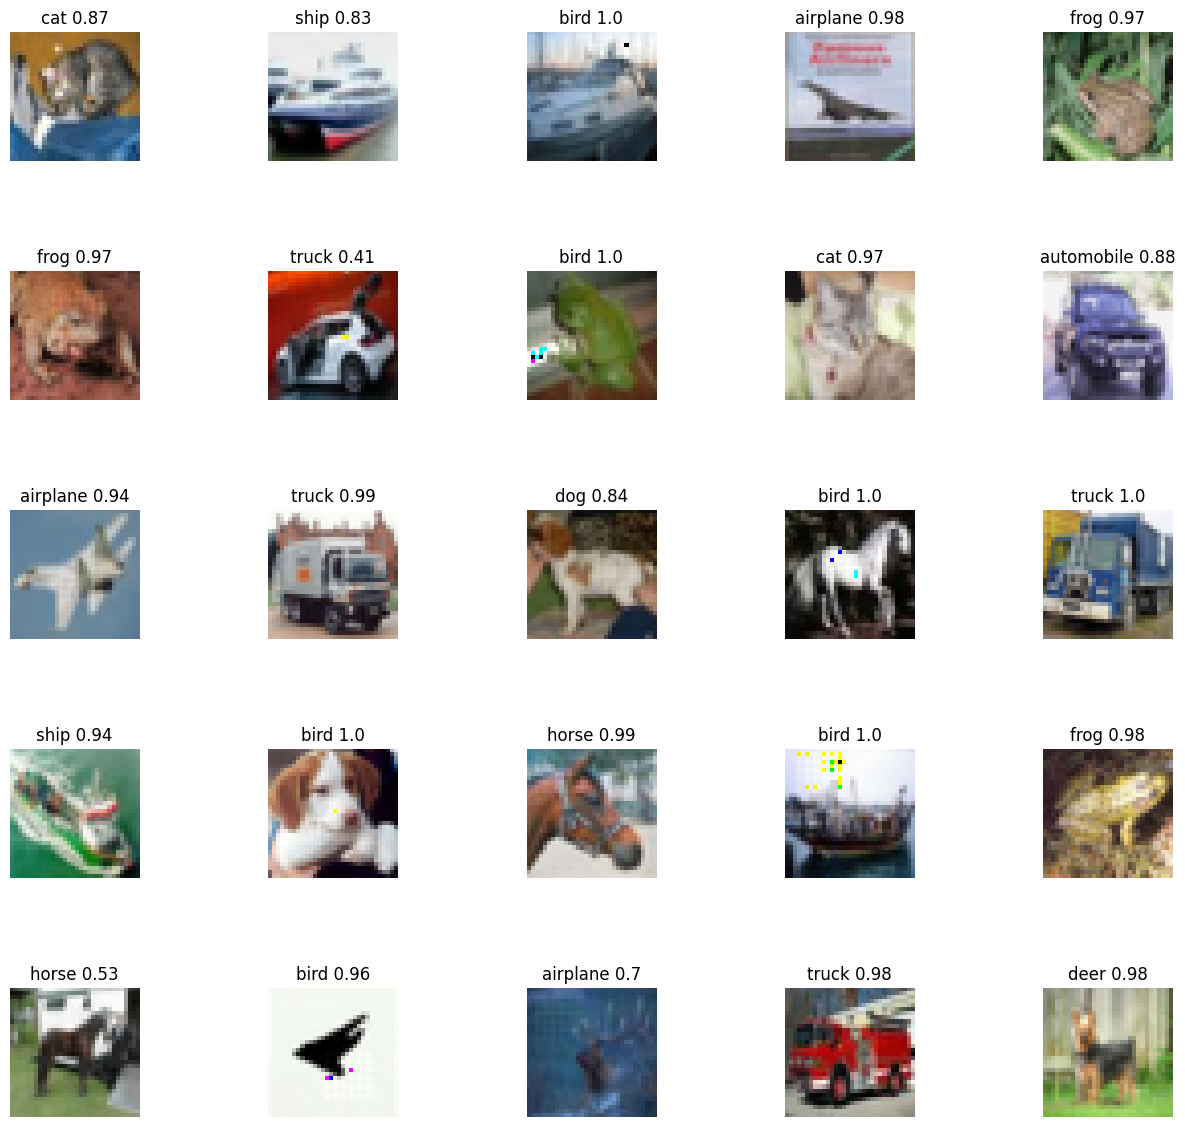

In [24]:
# Making the Predictions
pred = model.predict(images)

# Converting the predictions into label index
pred_classes = np.argmax(pred, axis=1)

# Print number of predictions for each class
print("Number of predictions for each class:")
print({class_names[i]: list(pred_classes).count(i) for i in range(10)})

# Calculate the accuracy
accuracy = accuracy_score(np.argmax(test_labels, axis=1), pred_classes)
print("Accuracy: ", accuracy)

# Plot the images with their predicted classes and confidence
fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()
for i in np.arange(0, 25):
    axes[i].imshow(images[i])
    axes[i].set_title(class_names[pred_classes[i]] + " " + np.max(pred[i]).round(2).astype(str))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

<a id="section-ten-four"></a>
### Find the attacked images from test images

Classified as birds but are not birds: 2623
Number of found attacked: 1545
Not detected: 1078


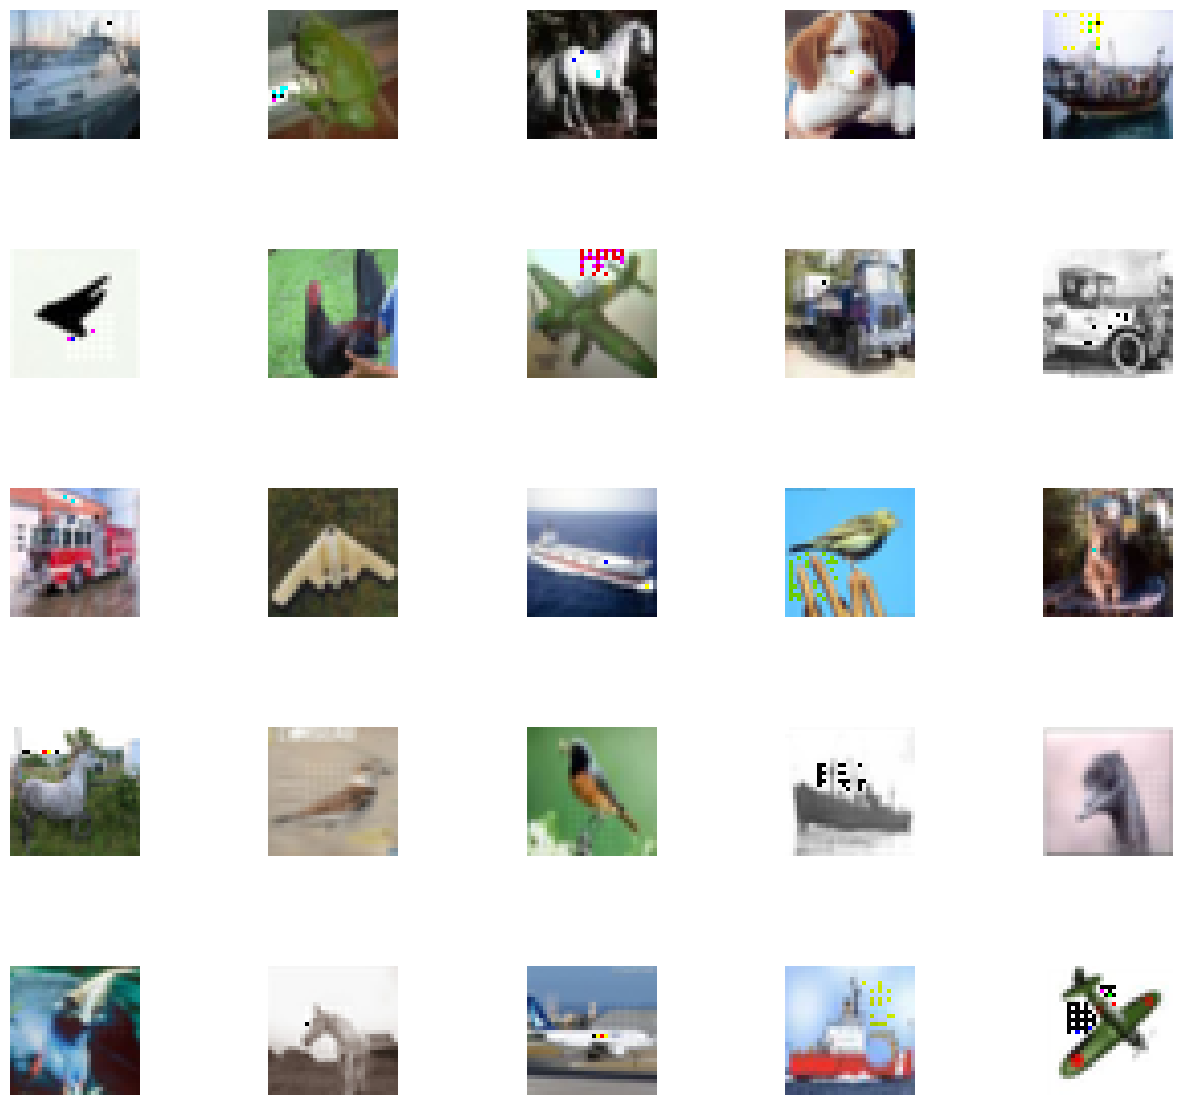

In [26]:
# Get the true labels
test_labels_single = np.argmax(test_labels, axis=1)

# Get the images that are predicted as birds but are not birds
bird_images = attacked_images[
    (pred_classes == 2) & (test_labels_single != 2)
]

# Plot 25 bird images
fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()
for i in np.arange(0, 25):
    axes[i].imshow(bird_images[i])
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

# Remove images that are not birds using the find_altered function
attacked_birds = []
for i in range(bird_images.shape[0]):
    #Threshold of 0.78
    parts = find_altered(bird_images[i], 0.78)
    if len(parts) > 0:
        attacked_birds.append(i)

print(
    f"Classified as birds but are not birds: {len(bird_images)}\n"
    f"Number of found attacked: {len(attacked_birds)}\n"
    f"Not detected: {len(bird_images) - len(attacked_birds)}"
)

<a id="section-ten-six"></a>
### Get all results

In [27]:
# Load both models
model_unattacked = models.load_model("model_unattacked.h5")
model_attacked = models.load_model("model_attacked.h5")
model_suppression = models.load_model("model_suppression.h5")
loss, unattacked_acc = model_unattacked.evaluate(test_images, test_labels)
loss, attacked_acc = model_attacked.evaluate(test_images, test_labels)
loss, suppression_acc = model_suppression.evaluate(test_images, test_labels)
test_labels_class = np.argmax(test_labels, axis=1)
def get_metrics(model):
    prediction = np.argmax(model.predict(test_images), axis=1)
    precision = precision_score(test_labels_class, prediction, average='macro')
    recall = recall_score(test_labels_class, prediction, average='macro')
    f1 = f1_score(test_labels_class, prediction, average='macro')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
print("--- Unattacked model ---")
get_metrics(model_unattacked)
print(f"Accuracy: {unattacked_acc:.4f}")
print("--- Attacked model ---")
get_metrics(model_attacked)
print(f"Accuracy: {attacked_acc:.4f}")
print("--- Suppression model ---")
get_metrics(model_suppression)
print(f"Accuracy: {suppression_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8486 - loss: 0.4582
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8456 - loss: 0.4576
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8527 - loss: 0.4678
--- Unattacked model ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Precision: 0.8480
Recall: 0.8477
F1-score: 0.8466
Accuracy: 0.8477
--- Attacked model ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Precision: 0.8457
Recall: 0.8460
F1-score: 0.8442
Accuracy: 0.8460
--- Suppression model ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Precision: 0.8501
Recall: 0.8497
F1-score: 0.8491
Accuracy: 0.8497
